<a href="https://colab.research.google.com/github/Manu-Sanchez/Learning/blob/ai%2Fbasic-gan/%5BExercise_Insurance%5D_FeatureEngineering_TabularModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Kaggle Data: https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

%matplotlib inline

In [2]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [51]:
df["charges"].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [19]:
categorical_columns = ["sex", "smoker", "region"]
continuous_columns = ["age", "bmi", "children"]
label_column = "charges"

#Categorical Data
categorical_data = []
categorical_embeddings = []
categorical_data_mapping = {}

for col_name in categorical_columns:
  categorical_column_data = df[col_name].astype("category")
  categorical_data_mapping[col_name] = categorical_column_data.cat.categories.values

  num_of_categories = len(categorical_column_data.cat.categories.values)
  categorical_embeddings.append((num_of_categories, min(50, (num_of_categories + 1) // 2)))

  categorical_data.append(categorical_column_data.cat.codes.values)

categorical_data = np.stack(categorical_data, axis=1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Continuous Data
continuous_data = []

for col_name in continuous_columns:
  continuous_data.append(df[col_name].values)

continuous_data = np.stack(continuous_data, axis=1)
continuous_data = torch.tensor(continuous_data, dtype=torch.float32)

#Label Data
label_data = df[label_column].values
label_data = torch.tensor(label_data, dtype=torch.float32).reshape(-1, 1)

print(f"Categorical data shape: {categorical_data.shape}\n" + \
      f"Continuous data shape: {continuous_data.shape}\n" + \
      f"Label data shape: {label_data.shape}\n" + \
      f"Categorical Embedding information: {categorical_embeddings}")

Categorical data shape: torch.Size([1338, 3])
Continuous data shape: torch.Size([1338, 3])
Label data shape: torch.Size([1338, 1])
Categorical Embedding information: [(2, 1), (2, 1), (4, 2)]


In [27]:
nRows, nCols = df.shape
train_size = int(nRows * 0.8)
test_size = nRows - train_size

categorical_train_data = categorical_data[:train_size]
categorical_test_data = categorical_data[train_size:]

continuous_train_data = continuous_data[:train_size]
continuous_test_data = continuous_data[train_size:]

label_train_data = label_data[:train_size]
label_test_data = label_data[train_size:]

print(
    f"Train Size: {train_size}\n" + \
    f"Test Size: {test_size}\n" + \
    f"Categorical Train Size: {categorical_train_data.shape}\n" + \
    f"Categorical Test Size: {categorical_test_data.shape}\n" + \
    f"Continuous Train Size: {continuous_train_data.shape}\n" + \
    f"Continuous Test Size: {continuous_test_data.shape}\n" + \
    f"Label Train Size: {label_train_data.shape}\n" + \
    f"Label Test Size: {label_test_data.shape}"
)

Train Size: 1070
Test Size: 268
Categorical Train Size: torch.Size([1070, 3])
Categorical Test Size: torch.Size([268, 3])
Continuous Train Size: torch.Size([1070, 3])
Continuous Test Size: torch.Size([268, 3])
Label Train Size: torch.Size([1070, 1])
Label Test Size: torch.Size([268, 1])


In [71]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()

        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        # Assign a variable to hold a list of layers
        layerlist = []

        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)

        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)

        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)

        # Set up model layers
        x = self.layers(x)
        return x

model = TabularModel(categorical_embeddings, len(continuous_columns), 1, [200, 100], 0.25)

In [67]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [68]:
epochs = 7000
losses = []

for i in range(epochs):

  predicted_label = model(categorical_train_data, continuous_train_data)
  loss = torch.sqrt(criterion(predicted_label, label_train_data))


  if i%100 == 0:
    print(f"Epoch {i} loss {loss}")
    losses.append(loss.detach().numpy())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  i += 1

Epoch 0 loss 17868.712890625
Epoch 100 loss 17862.12109375
Epoch 200 loss 17848.859375
Epoch 300 loss 17828.125
Epoch 400 loss 17801.734375
Epoch 500 loss 17771.84765625
Epoch 600 loss 17735.16015625
Epoch 700 loss 17687.333984375
Epoch 800 loss 17645.626953125
Epoch 900 loss 17586.966796875
Epoch 1000 loss 17536.62890625
Epoch 1100 loss 17474.337890625
Epoch 1200 loss 17413.158203125
Epoch 1300 loss 17334.033203125
Epoch 1400 loss 17259.0703125
Epoch 1500 loss 17191.890625
Epoch 1600 loss 17102.5859375
Epoch 1700 loss 17007.392578125
Epoch 1800 loss 16919.15625
Epoch 1900 loss 16817.421875
Epoch 2000 loss 16704.400390625
Epoch 2100 loss 16641.263671875
Epoch 2200 loss 16548.9140625
Epoch 2300 loss 16389.390625
Epoch 2400 loss 16316.2744140625
Epoch 2500 loss 16193.521484375
Epoch 2600 loss 16091.9755859375
Epoch 2700 loss 15951.6591796875
Epoch 2800 loss 15822.0625
Epoch 2900 loss 15656.318359375
Epoch 3000 loss 15562.4140625
Epoch 3100 loss 15520.9892578125
Epoch 3200 loss 15397.3095

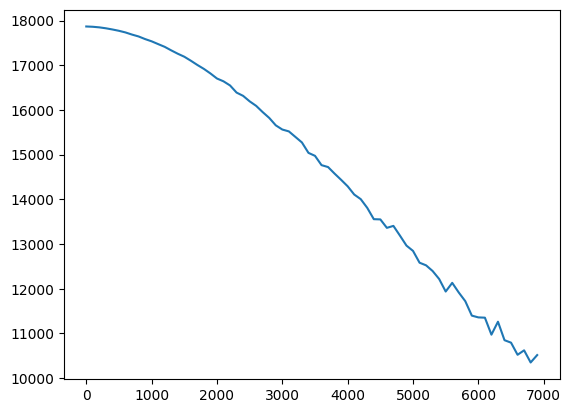

In [69]:
plt.plot(range(0, epochs, 100), losses)
plt.show()

In [70]:
with torch.no_grad():
  predicted_test_values = model(categorical_test_data, continuous_test_data)

  loss = torch.sqrt(criterion(predicted_test_values, label_test_data))

print(loss)

tensor(11013.0254)


In [55]:
for pred, curr in zip(predicted_test_values, label_test_data):
  diff = np.abs(pred - curr)
  print(f"Predicted: {pred.item()}, Current: {curr.item()}, Difference: {diff.item()}")

Predicted: 35594.19140625, Current: 39871.703125, Difference: 4277.51171875
Predicted: 15711.2783203125, Current: 13974.455078125, Difference: 1736.8232421875
Predicted: 1259.258544921875, Current: 1909.5274658203125, Difference: 650.2689208984375
Predicted: 14314.2822265625, Current: 12096.6513671875, Difference: 2217.630859375
Predicted: 11440.720703125, Current: 13204.2861328125, Difference: 1763.5654296875
Predicted: 4482.1728515625, Current: 4562.84228515625, Difference: 80.66943359375
Predicted: 10358.4423828125, Current: 8551.3466796875, Difference: 1807.095703125
Predicted: 4723.48828125, Current: 2102.2646484375, Difference: 2621.2236328125
Predicted: 9010.39453125, Current: 34672.1484375, Difference: 25661.75390625
Predicted: 26651.72265625, Current: 15161.5341796875, Difference: 11490.1884765625
Predicted: 4540.43310546875, Current: 11884.048828125, Difference: 7343.61572265625
Predicted: 3853.8935546875, Current: 4454.40283203125, Difference: 600.50927734375
Predicted: 6234